In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from xgboost import XGBClassifier


training_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [36]:
def process_data(data):
    data = data.drop(['Name', 'Ticket'], axis=1) 
    
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0]) 
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())  

    data['Cabin'] = data['Cabin'].fillna('Unknown')  
    data['Deck'] = data['Cabin'].str[0].replace('U', 'Unknown') 
    data['Has_cabin'] = (data['Cabin'] != 'Unknown').astype(int)  
    
    data['Num_cabins'] = data['Cabin'].str.count(' ') + 1 

    data = pd.get_dummies(data, columns=['Embarked', 'Sex', 'Deck'], drop_first=False)

    data = data.drop('Cabin', axis=1) 
    return data

In [37]:
training_data = process_data(training_data)
test_data = process_data(test_data)

X = training_data.drop('Survived', axis=1)
y = training_data['Survived']

X_testing = test_data.reindex(columns=X.columns, fill_value=0)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_testing = scaler.transform(X_testing)

In [38]:
model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Validation accuracy: 0.8156
precision: 0.7971
recall: 0.7432
F1 score: 0.7692
ROC-AUC score: 0.8685


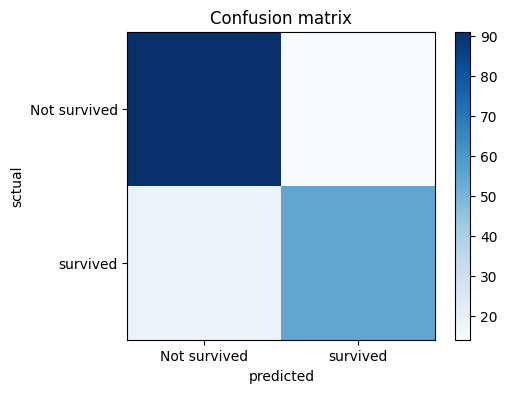

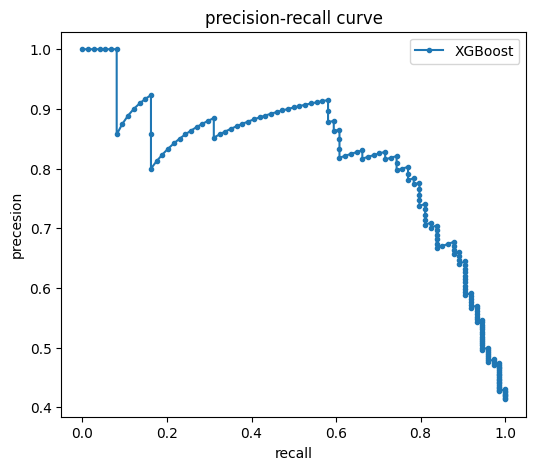

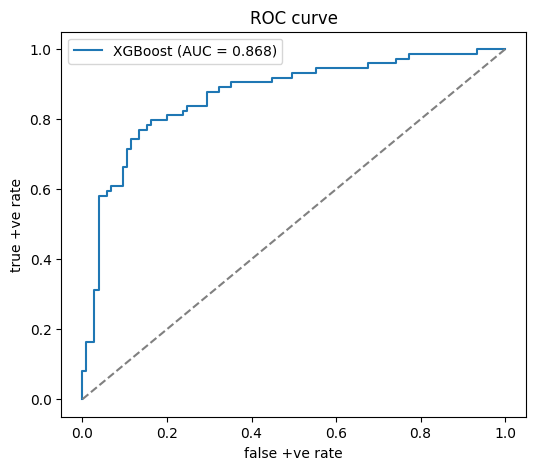

In [39]:
y_valid_pred = model.predict(X_valid)
y_valid_pred_prob = model.predict_proba(X_valid)[:, 1]

accuracy = accuracy_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred)
recall = recall_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)
roc_auc = roc_auc_score(y_valid, y_valid_pred_prob)

print(f"Validation accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"ROC-AUC score: {roc_auc:.4f}")

conf_matrix = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(5, 4))
plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks([0, 1], ['Not survived', 'survived'])
plt.yticks([0, 1], ['Not survived', 'survived'])
plt.xlabel("predicted")
plt.ylabel("sctual")
plt.title("Confusion matrix")
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(y_valid, y_valid_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, marker='.', label="XGBoost")
plt.xlabel("recall")
plt.ylabel("precesion")
plt.title("precision-recall curve")
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_valid, y_valid_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("false +ve rate")
plt.ylabel("true +ve rate")
plt.title("ROC curve")
plt.legend()
plt.show()

In [40]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': model.predict(X_testing)})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
